In [1]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
import random
%matplotlib inline


Using TensorFlow backend.


In [2]:
criss_cross = np.array([
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.]
])


In [3]:
visited_mark = 0.8  # Cells visited by the robot will be painted by gray 0.8
robot_mark = 0.5      # The current robot cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

# Explorobotion factor
epsilon = 0.1


In [4]:
class Qcriss_cross(object):
    def __init__(self, criss_cross, robot=(0,0)):
        self._criss_cross = np.array(criss_cross)
        nrows, ncols = self._criss_cross.shape
        self.target = (nrows-1, ncols-1)   # target cell where the "product" is
        self.open_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._criss_cross[r,c] == 1.0]
        self.open_cells.remove(self.target)
        if self._criss_cross[self.target] == 0.0:
            raise Exception("Invalid criss_cross: target cell cannot be blocked!")
        if not robot in self.open_cells:
            raise Exception("Invalid robot Location: must sit on a free cell")
        self.reset(robot)

    def reset(self, robot):
        self.robot = robot
        self.criss_cross = np.copy(self._criss_cross)
        nrows, ncols = self.criss_cross.shape
        row, col = robot
        self.criss_cross[row, col] = robot_mark
        self.state = (row, col, 'start')
        self.min_reward = -0.5 * self.criss_cross.size
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.criss_cross.shape
        nrow, ncol, nmode = robot_row, robot_col, mode = self.state

        if self.criss_cross[robot_row, robot_col] > 0.0:
            self.visited.add((robot_row, robot_col))  # mark visited cell

        valid_actions = self.valid_actions()
                
        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        else:                  # invalid action, no change in robot position
            mode = 'invalid'

        # new state
        self.state = (nrow, ncol, nmode)

    def get_reward(self):
        robot_row, robot_col, mode = self.state
        nrows, ncols = self.criss_cross.shape
        if robot_row == nrows-1 and robot_col == ncols-1:
            return 1.0
        if mode == 'blocked':
            return self.min_reward - 1
        if (robot_row, robot_col) in self.visited:
            return -0.25
        if mode == 'invalid':
            return -0.75
        if mode == 'valid':
            return -0.04

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.criss_cross)
        nrows, ncols = self.criss_cross.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the robot
        row, col, valid = self.state
        canvas[row, col] = robot_mark
        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        robot_row, robot_col, mode = self.state
        nrows, ncols = self.criss_cross.shape
        if robot_row == nrows-1 and robot_col == ncols-1:
            return 'win'

        return 'not_over'

    def valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.criss_cross.shape
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)

        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)

        if row>0 and self.criss_cross[row-1,col] == 0.0:
            actions.remove(1)
        if row<nrows-1 and self.criss_cross[row+1,col] == 0.0:
            actions.remove(3)

        if col>0 and self.criss_cross[row,col-1] == 0.0:
            actions.remove(0)
        if col<ncols-1 and self.criss_cross[row,col+1] == 0.0:
            actions.remove(2)

        return actions



In [5]:
def show(qcriss_cross):
    plt.grid('on')
    nrows, ncols = qcriss_cross.criss_cross.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qcriss_cross.criss_cross)
    for row,col in qcriss_cross.visited:
        canvas[row,col] = 0.6
    robot_row, robot_col, _ = qcriss_cross.state
    canvas[robot_row, robot_col] = 0.3   # robot cell
    canvas[8,6 ] = 0.9 # product cell
    
    img = plt.imshow(canvas, interpolation='none', cmap='gray',animated=True)
    plt.savefig('books_read.png')
    a = np.asarray(canvas)
    np.savetxt("foo.csv", a, delimiter=",")
    return img



reward= -0.04


/home/prashant/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


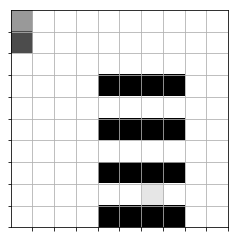

In [6]:
qcriss_cross = Qcriss_cross(criss_cross)
canvas, reward, game_over = qcriss_cross.act(DOWN)
print("reward=", reward)
show(qcriss_cross)

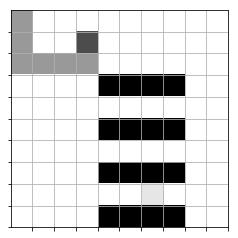

In [7]:
qcriss_cross.act(DOWN)  # move down
qcriss_cross.act(RIGHT)  # move right
qcriss_cross.act(RIGHT)  # move right
qcriss_cross.act(RIGHT)  # move right
qcriss_cross.act(UP)  # move up
show(qcriss_cross)


In [8]:
def play_game(model, qcriss_cross, robot_cell):
    qcriss_cross.reset(robot_cell)
    envstate = qcriss_cross.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qcriss_cross.act(action)
        show(qcriss_cross)
        if game_status == 'win':
            
            return True
        elif game_status == 'lose':
            return False



In [9]:

def completion_check(model, qcriss_cross):
    for cell in qcriss_cross.open_cells:
        if not qcriss_cross.valid_actions(cell):
            return False
        if not play_game(model, qcriss_cross, cell):
            return False
    return True



# Q-Training


In [10]:

class Experience(object):
    def __init__(self, model, max_memory=100, discount=0.95):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.output_shape[-1]

    def remember(self, episode):
        # episode = [envstate, action, reward, envstate_next, game_over]
        # memory[i] = episode
        # envstate == flattened 1d criss_cross cells info, including robot cell (see method: observe)
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, envstate):
        return self.model.predict(envstate)[0]

    def get_data(self, data_size=10):
        env_size = self.memory[0][0].shape[1]   # envstate 1d size (1st element of episode)
        mem_size = len(self.memory)
        data_size = min(mem_size, data_size)
        inputs = np.zeros((data_size, env_size))
        targets = np.zeros((data_size, self.num_actions))
        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            envstate, action, reward, envstate_next, game_over = self.memory[j]
            inputs[i] = envstate
            # There should be no target values for actions not taken.
            targets[i] = self.predict(envstate)
            # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
            Q_sa = np.max(self.predict(envstate_next))
            if game_over:
                targets[i, action] = reward
            else:
                # reward + gamma * max_a' Q(s', a')
                targets[i, action] = reward + self.discount * Q_sa
        return inputs, targets



n_epoch - Number of training epochs

max_memory - Maximum number of game experiences we 
keep in memory (see the Experince class above)
    
    data_size - Number of samples we use in each training epoch. 
    
    This is the number episodes (or game experiences) which we randomly select from our experiences repository (again, see the Experience class above)


In [11]:

def qtrain(model, criss_cross, **opt):
    global epsilon
    n_epoch = opt.get('n_epoch', 15000)
    max_memory = opt.get('max_memory', 1000)
    data_size = opt.get('data_size', 50)
    weights_file = opt.get('weights_file', "")
    name = opt.get('name', 'model')
    start_time = datetime.datetime.now()

    # If you want to continue training from a previous model,
    # just supply the h5 file name to weights_file option
    if weights_file:
        print("loading weights from file: %s" % (weights_file,))
        model.load_weights(weights_file)

    # Construct environment/game from numpy array: criss_cross (see above)
    qcriss_cross = Qcriss_cross(criss_cross)

    # Initialize experience replay object
    experience = Experience(model, max_memory=max_memory)

    win_history = []   # history of win/lose game
    n_open_cells = len(qcriss_cross.open_cells)
    hsize = qcriss_cross.criss_cross.size//2   # history window size
    win_robote = 0.0
    imctr = 1

    for epoch in range(n_epoch):
        loss = 0.0
        robot_cell = random.choice(qcriss_cross.open_cells)
        qcriss_cross.reset(robot_cell)
        game_over = False

        # get initial envstate (1d flattened canvas)
        envstate = qcriss_cross.observe()

        n_episodes = 0
        while not game_over:
            valid_actions = qcriss_cross.valid_actions()
            if not valid_actions: break
            prev_envstate = envstate
            # Get next action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(prev_envstate))

            # Apply action, get reward and new envstate
            envstate, reward, game_status = qcriss_cross.act(action)
            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            else:
                game_over = False

            # Store episode (experience)
            episode = [prev_envstate, action, reward, envstate, game_over]
            experience.remember(episode)
            n_episodes += 1

            # Train neural network model
            inputs, targets = experience.get_data(data_size=data_size)
            h = model.fit(
                inputs,
                targets,
                epochs=8,
                batch_size=16,
                verbose=0,
            )
            loss = model.evaluate(inputs, targets, verbose=0)

        if len(win_history) > hsize:
            win_robote = sum(win_history[-hsize:]) / hsize
    
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win robote: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_robote, t))
        plt.show(qcriss_cross)
        # we simply check if training has exhausted all free cells and if in all
        # cases the agent won
        if win_robote > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qcriss_cross):
            print("Reached 100%% win robote at epoch: %d" % (epoch,))
            break

    # Save trained model weights and architecture, this will be used by the visualization code
    model.save('Model.h5')
    end_time = datetime.datetime.now()
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print('Model_saved')
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)



# Building a Neural Network Model

In [12]:
def build_model(criss_cross, lr=0.001):
    model = Sequential()
    model.add(Dense(criss_cross.size, input_shape=(criss_cross.size,)))
    model.add(PReLU())
    model.add(Dense(criss_cross.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model



Epoch: 000/14999 | Loss: 0.0405 | Episodes: 240 | Win count: 0 | Win robote: 0.000 | time: 36.9 seconds
Epoch: 001/14999 | Loss: 0.0017 | Episodes: 227 | Win count: 0 | Win robote: 0.000 | time: 62.5 seconds
Epoch: 002/14999 | Loss: 0.0016 | Episodes: 46 | Win count: 1 | Win robote: 0.000 | time: 67.7 seconds
Epoch: 003/14999 | Loss: 0.0048 | Episodes: 36 | Win count: 2 | Win robote: 0.000 | time: 71.7 seconds
Epoch: 004/14999 | Loss: 0.0035 | Episodes: 14 | Win count: 3 | Win robote: 0.000 | time: 73.3 seconds
Epoch: 005/14999 | Loss: 0.0019 | Episodes: 14 | Win count: 4 | Win robote: 0.000 | time: 74.9 seconds
Epoch: 006/14999 | Loss: 0.0419 | Episodes: 137 | Win count: 5 | Win robote: 0.000 | time: 90.4 seconds
Epoch: 007/14999 | Loss: 0.1122 | Episodes: 164 | Win count: 6 | Win robote: 0.000 | time: 108.8 seconds
Epoch: 008/14999 | Loss: 0.0131 | Episodes: 23 | Win count: 7 | Win robote: 0.000 | time: 111.4 seconds
Epoch: 009/14999 | Loss: 0.0309 | Episodes: 28 | Win count: 8 | Win

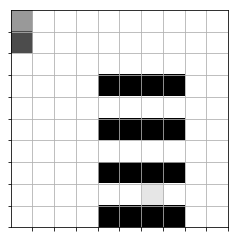

Epoch: 053/14999 | Loss: 0.0014 | Episodes: 4 | Win count: 52 | Win robote: 1.000 | time: 8.99 minutes


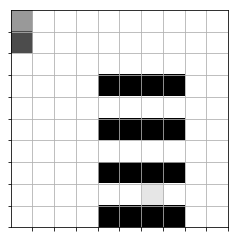

Epoch: 054/14999 | Loss: 0.0020 | Episodes: 11 | Win count: 53 | Win robote: 1.000 | time: 12.11 minutes


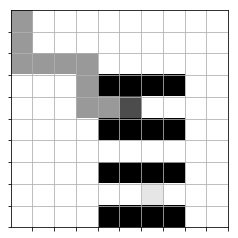

Epoch: 055/14999 | Loss: 0.0027 | Episodes: 5 | Win count: 54 | Win robote: 1.000 | time: 15.18 minutes


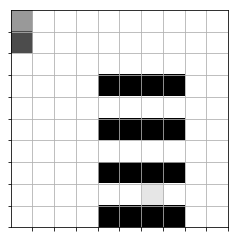

Epoch: 056/14999 | Loss: 0.0014 | Episodes: 13 | Win count: 55 | Win robote: 1.000 | time: 18.31 minutes


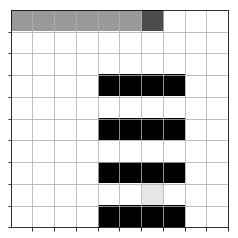

Epoch: 057/14999 | Loss: 0.0033 | Episodes: 13 | Win count: 56 | Win robote: 1.000 | time: 48.05 minutes


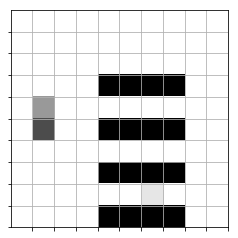

In [ ]:
model = build_model(criss_cross)
qtrain(model, criss_cross, epochs=10, max_memory=8*criss_cross.size, data_size=32)


In [95]:
saved_model = load_model('Model.h5')

In [96]:
from keras.utils import plot_model
plot_model(saved_model, to_file='model.png')

In [1]:
open_cell = random.choice(qcriss_cross.open_cells)
play_game(saved_model,qcriss_cross,(0,3))

NameError: name 'random' is not defined